#### In this notebook we will be implementing the convolutional autoencoder, which simply means we will be using CNN layers instead of fully connected dense layers.


In [1]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision.transforms import transforms
import numpy as np

In [2]:
# Set device to cuda 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda


In [3]:
# set up the transformations required for the training and testing data
# convert to tensor, normalize and move to cuda
image_transform = transforms.Compose([
    transforms.ToTensor(),transforms.Normalize([0.5], [0.5]),transforms.Lambda(lambda x : x.to(device))
])

In [4]:
# Creating training and testing datasets
train_dataset = MNIST(root='./MnistDataset', train=True, transform=image_transform, download=True)
validation_dataset = MNIST(root='./MnistDataset', train=False, transform=image_transform, download=True)

In [5]:
# Set up the dataloaders
from torch.utils.data import DataLoader
batch_size = 128

trainLoader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validationLoader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

In [6]:
class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Define encoder architecture
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=1) 
        )
        
        # define the decoder architecture
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=32, kernel_size=3, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=32, out_channels=16,kernel_size=5, stride=3, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=2, stride=2, padding=1),
            nn.Tanh()
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        
        return x


In [7]:
from torchsummary import summary
model = ConvAutoEncoder().to(device)
summary(model, torch.zeros(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 128, 2, 2]           --
|    └─Conv2d: 2-1                       [-1, 32, 10, 10]          320
|    └─ReLU: 2-2                         [-1, 32, 10, 10]          --
|    └─MaxPool2d: 2-3                    [-1, 32, 5, 5]            --
|    └─Conv2d: 2-4                       [-1, 128, 3, 3]           36,992
|    └─ReLU: 2-5                         [-1, 128, 3, 3]           --
|    └─MaxPool2d: 2-6                    [-1, 128, 2, 2]           --
├─Sequential: 1-2                        [-1, 1, 28, 28]           --
|    └─ConvTranspose2d: 2-7              [-1, 32, 5, 5]            36,896
|    └─ReLU: 2-8                         [-1, 32, 5, 5]            --
|    └─ConvTranspose2d: 2-9              [-1, 16, 15, 15]          12,816
|    └─ReLU: 2-10                        [-1, 16, 15, 15]          --
|    └─ConvTranspose2d: 2-11             [-1, 1, 28, 28]           65
| 

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 128, 2, 2]           --
|    └─Conv2d: 2-1                       [-1, 32, 10, 10]          320
|    └─ReLU: 2-2                         [-1, 32, 10, 10]          --
|    └─MaxPool2d: 2-3                    [-1, 32, 5, 5]            --
|    └─Conv2d: 2-4                       [-1, 128, 3, 3]           36,992
|    └─ReLU: 2-5                         [-1, 128, 3, 3]           --
|    └─MaxPool2d: 2-6                    [-1, 128, 2, 2]           --
├─Sequential: 1-2                        [-1, 1, 28, 28]           --
|    └─ConvTranspose2d: 2-7              [-1, 32, 5, 5]            36,896
|    └─ReLU: 2-8                         [-1, 32, 5, 5]            --
|    └─ConvTranspose2d: 2-9              [-1, 16, 15, 15]          12,816
|    └─ReLU: 2-10                        [-1, 16, 15, 15]          --
|    └─ConvTranspose2d: 2-11             [-1, 1, 28, 28]           65
| 

In [8]:
# Training batch
def trainBatch(input, model, criterion, optimiser):
    model.train()
    optimiser.zero_grad()
    output = model(input)
    loss = criterion(output, input)
    loss.backward()
    optimiser.step()
    return loss

In [9]:
# validation batch
@torch.no_grad()
def validBatch(input, model, criterion):
    model.eval()
    output = model(input)
    loss = criterion(output, input)
    return loss

In [10]:
model = ConvAutoEncoder().to(device)
criterion = nn.MSELoss()
optimiser = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

EPOCH: 1.000  trn_loss: 0.221  val_loss: 0.092  (5.53s - 49.73s remaining)
EPOCH: 2.000  trn_loss: 0.080  val_loss: 0.068  (10.82s - 43.29s remaining)
EPOCH: 3.000  trn_loss: 0.065  val_loss: 0.059  (16.18s - 37.76s remaining)
EPOCH: 4.000  trn_loss: 0.057  val_loss: 0.053  (21.48s - 32.22s remaining)
EPOCH: 5.000  trn_loss: 0.052  val_loss: 0.049  (26.92s - 26.92s remaining)
EPOCH: 6.000  trn_loss: 0.049  val_loss: 0.047  (32.34s - 21.56s remaining)
EPOCH: 7.000  trn_loss: 0.046  val_loss: 0.044  (37.66s - 16.14s remaining)
EPOCH: 8.000  trn_loss: 0.045  val_loss: 0.044  (43.00s - 10.75s remaining)
EPOCH: 9.000  trn_loss: 0.043  val_loss: 0.042  (48.35s - 5.37s remaining)
EPOCH: 10.000  trn_loss: 0.042  val_loss: 0.040  (53.69s - 0.00s remaining)


100%|██████████| 111/111 [00:00<00:00, 3140.87it/s]


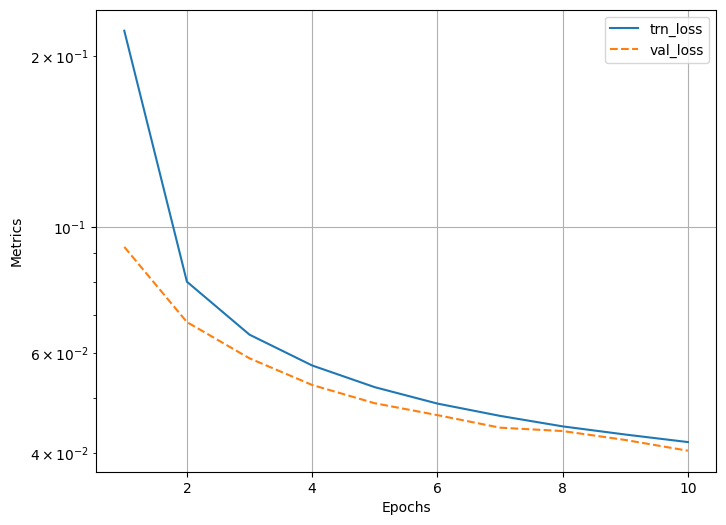

In [11]:
# Train model over increasing epochs
numEpochs = 10

# report
from torch_snippets import Report
log = Report(numEpochs)

for epoch in range(numEpochs):
    N = len(trainLoader)
    
    for index,(image,label) in enumerate(trainLoader):
        loss = trainBatch(image, model, criterion, optimiser)
        log.record(pos=(epoch + (index+1)/N), trn_loss=loss,end = '\r')
    
    N = len(validationLoader)
    for index,(image,label) in enumerate(validationLoader):
        loss = validBatch(image, model, criterion)
        log.record(pos=(epoch + (index+1)/N), val_loss=loss,end = '\r')
    
    log.report_avgs(epoch+1)
log.plot_epochs(log=True)

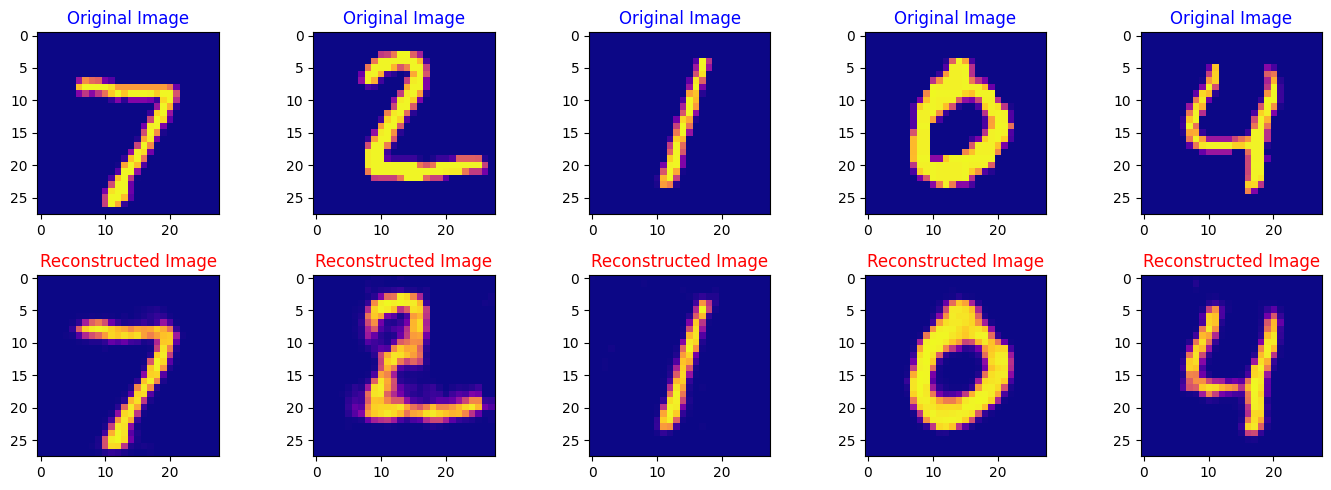

In [12]:
import matplotlib.pyplot as plt

# Create subplots with 2 rows and 5 columns, transposed
fig, axs = plt.subplots(2, 5, figsize=(14, 5))

# Iterate over 5 images in the validation set
for i in range(5):
    # Get the i-th image and send it to the device
    image, _ = validation_dataset[i]
    image = image.unsqueeze(0).to(device)
    
    # Generate the output using the model
    output = model(image)
    
    # Plot the original image
    axs[0, i].imshow(image.cpu().numpy().squeeze(), cmap='plasma')
    axs[0, i].set_title('Original Image', fontsize=12, color='blue')
    
    # Plot the reconstructed image
    axs[1, i].imshow(output.cpu().detach().numpy().squeeze(), cmap='plasma')
    axs[1, i].set_title('Reconstructed Image', fontsize=12, color='red')

# Adjust vertical spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


#### Here we will visualize the clustering

In [13]:
latent_vectors = []
classes = []

In [14]:
# Loop through validation dataloader and store output of each encoder layers
for image, label in validationLoader:
    latent_vectors.append(model.encoder(image).view(len(image),-1))
    classes.extend(label)
    
# Concatenate numpy array of latent vectors
latent_vectors = torch.cat(latent_vectors).cpu().detach().numpy()

In [15]:
# Import t-SNE and convert each latent vector into 2D space
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)

In [16]:
clustered = tsne.fit_transform(latent_vectors)

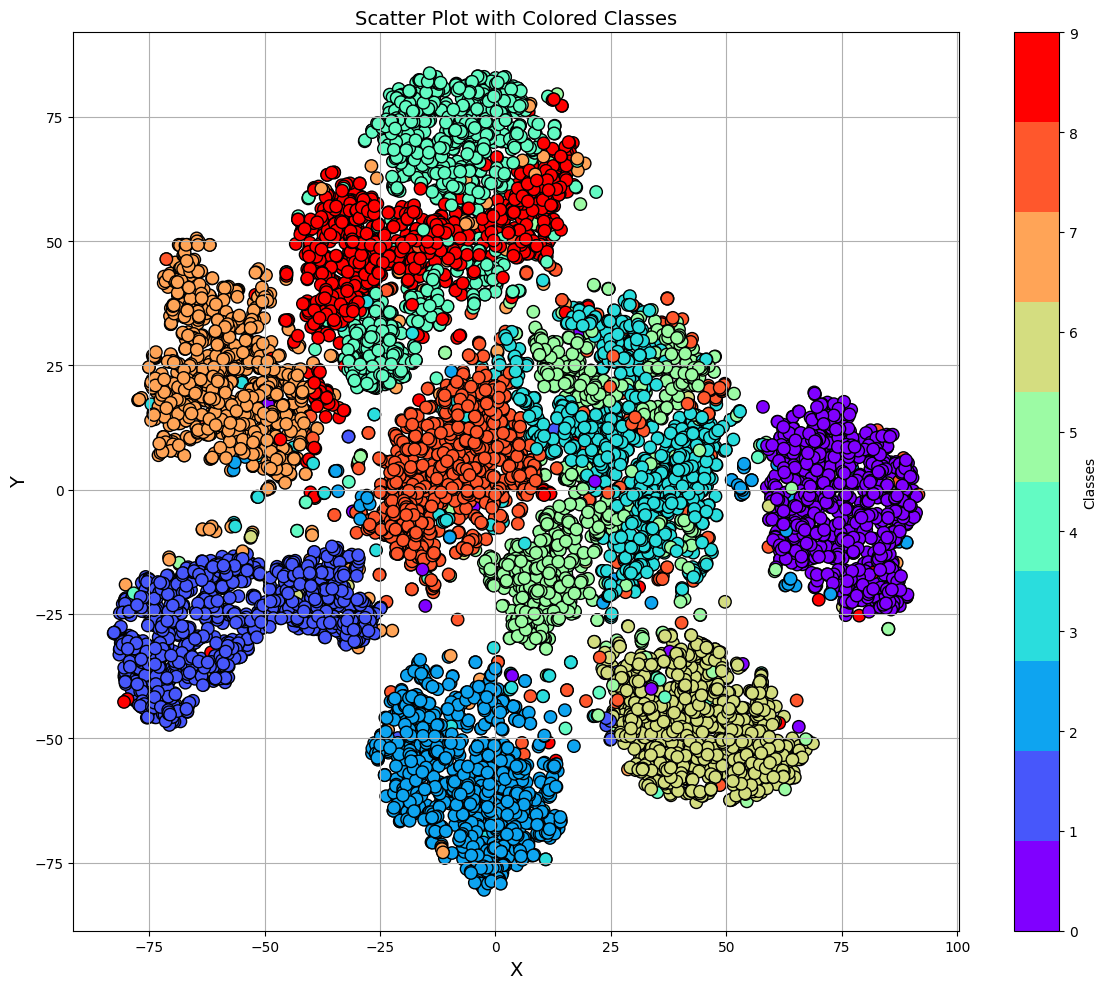

In [17]:
import matplotlib.pyplot as plt

# Plot
fig = plt.figure(figsize=(12, 10))

# Define colormap
cmap = plt.get_cmap('rainbow', 10)

# Scatter plot
plt.scatter(*zip(*clustered), c=classes, cmap=cmap, marker='o', s=80, edgecolors='k')

# Add colorbar
cbar = plt.colorbar()
cbar.set_label('Classes', fontsize=10)

# Set labels and title
plt.xlabel('X', fontsize=14)
plt.ylabel('Y', fontsize=14)
plt.title('Scatter Plot with Colored Classes', fontsize=14)

# Set colorbar ticks and labels
cbar.set_ticks(range(10))  # Adjust based on your classes
cbar.set_ticklabels(range(10))  # Adjust based on your class labels

# Show plot
plt.grid(True)
plt.tight_layout()
plt.show()


#### Generating new images from autoencoders

In [18]:
latent_vectors = []
classes = []
for im,clss in validationLoader:
    latent_vectors.append(model.encoder(im))
    classes.extend(clss)
latent_vectors = torch.cat(latent_vectors).cpu().detach().numpy().reshape(10000, -1)

In [19]:
print(len(latent_vectors), len(latent_vectors[0]))

10000 512


In [20]:
random_vectors = []
for columns in latent_vectors.transpose(1,0):
    mu, sigma = columns.mean(), columns.std()
    random_vectors.append(sigma*torch.randn(1,25) + mu)

In [21]:
print(len(random_vectors), len(random_vectors[0]))

512 1


In [22]:
random_vectors[0].shape

torch.Size([1, 25])

In [23]:
random_vectors = torch.cat(random_vectors).transpose(1,0).to(device)

In [24]:
print(random_vectors.shape) 

torch.Size([25, 512])


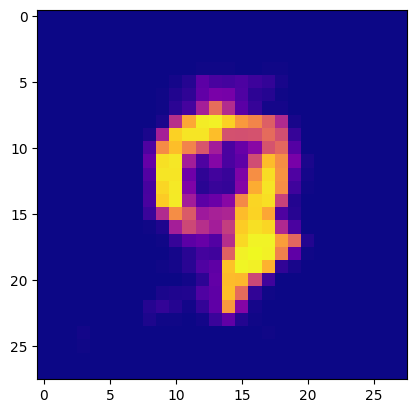

In [25]:
image = model.decoder(random_vectors[0].view(1,128,2,2)).view(28,28)

#plot this image
plt.imshow(image.cpu().detach().numpy().squeeze(), cmap='plasma')

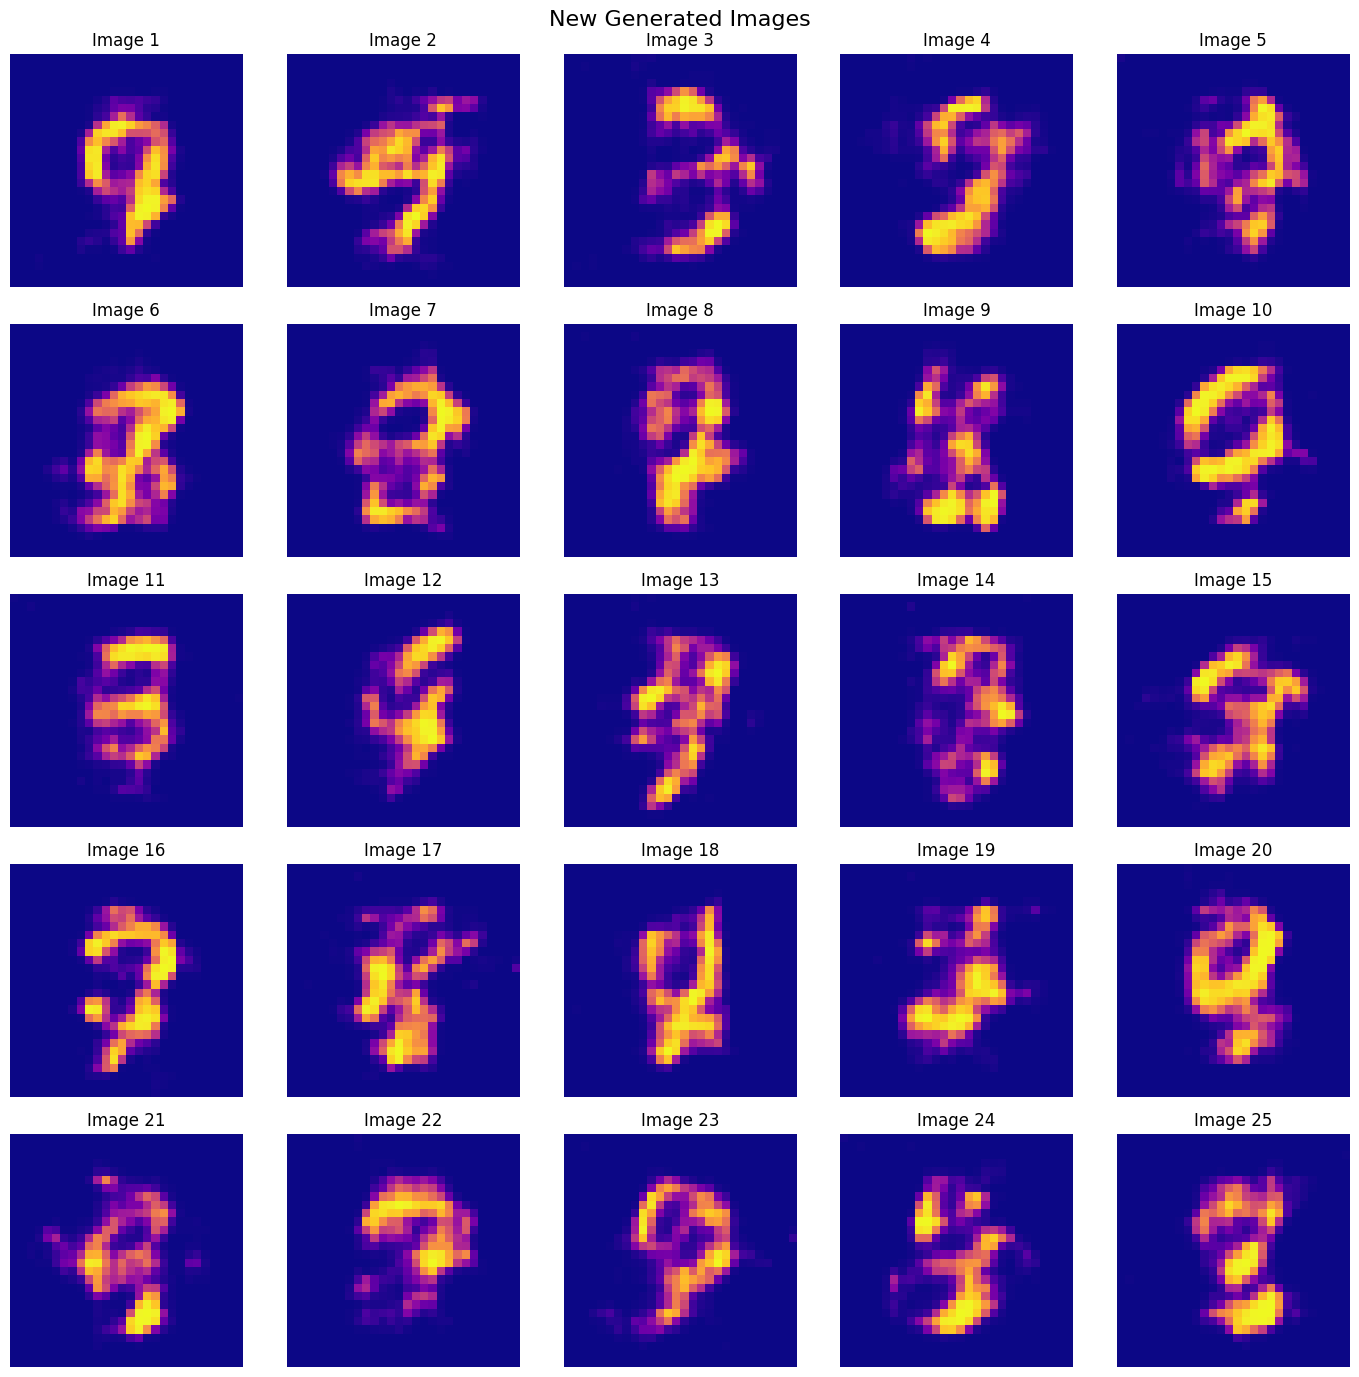

In [27]:
import matplotlib.pyplot as plt

# Create a 5x5 grid of subplots
fig, axs = plt.subplots(5, 5, figsize=(14, 14))

# Iterate through each subplot
for i in range(5):
    for j in range(5):
        # Generate image using decoder and random vector
        index = i * 5 + j
        random_vector = random_vectors[index].view(1, 128, 2, 2)
        image = model.decoder(random_vector).view(28, 28, 1)
        
        # Plot the image on the current subplot
        axs[i, j].imshow(image.cpu().detach().numpy().squeeze(), cmap='plasma')
        
        # Add image number as title
        axs[i, j].set_title(f'Image {index + 1}')
        
        # Turn off axis for cleaner plot
        axs[i, j].axis('off')

# Add title for the entire figure
fig.suptitle('New Generated Images', fontsize=16)

# Adjust layout for better visualization
plt.tight_layout()

# Show the plot
plt.show()
